CHEICK ISMAIL Mariyam 

ESILV A5 - DIA 3

# Feature engineering

An online merchant asks you to make real-time predictions for the customers of his 
website: when they are ready to buy, tell them the date of receipt of their product, for 
the various possible transport services. (Chronopost ..).
To do this, you have 6 weeks of order history with 3 pieces of information
- Date and time of the customer's order
- Shipment date (to simplify considered as order shipment date)
- Transport service
In production
- You will have a daily update (every night) of the warehouse status (this same updated 
file)
- You will need to be able to deliver real-time on-the-fly prediction with each new online 
order. The speed of your predictive model will be as important as its accuracy

## Strategy

In order to predict the expedition date regarding the provider, I have decided to find a delay between the order and the expedition. By doing so, we can easily add a delay to a date to predict the expedition date, whenever is the day given. 

For this problem, we are looking for a discrete numerical value, which means that sseing this problem as a regression one is more adequate. 

Splitting into train and test set is a question that we have to think about, but we first have to clean and explore our dataset and understand it before. 

## Data discovery

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')

# Load dataset
dataset = pd.read_csv('./datasets/logistique.csv')

In [2]:
dataset.head(15)

,datedecreationdecommande,providerservice_id,dateexpe
0,2019-11-01 11:40:35.9930000,48,02/11/2019
1,2019-11-01 11:40:35.9700000,48,02/11/2019
2,2019-11-01 10:24:40.8930000,48,02/11/2019
3,2019-11-01 14:24:21.1770000,48,02/11/2019
4,2019-11-01 13:28:35.7900000,48,02/11/2019
5,2019-11-01 19:40:04.2000000,48,02/11/2019
6,2019-11-01 06:16:55.8830000,48,02/11/2019
7,2019-11-01 18:42:10.0330000,48,02/11/2019
8,2019-11-01 21:05:23.9100000,48,02/11/2019
9,2019-11-01 15:46:58.7800000,48,02/11/2019


In [3]:
dataset.dtypes, dataset.shape

(datedecreationdecommande    object
 providerservice_id           int64
 dateexpe                    object
 dtype: object,
 (572841, 3))

### Clean dataset

In [4]:
# Seperate date and time of creation date
order_fulldate = pd.to_datetime(dataset['datedecreationdecommande'], format='%Y-%m-%d')
order_date = order_fulldate.dt.date.astype('datetime64')
order_time = order_fulldate.dt.floor('H').astype('datetime64').dt.time

# Format expedition date 
expedition_date = pd.to_datetime(dataset['dateexpe'], format='%d/%m/%Y').astype('datetime64')
expedition_date

# Creating a new dataframe with desired values 
df = pd.DataFrame(columns=[
    'provider_id', 
    'order_date',
    'order_time',
    'order_stock', 
    'expedition_date', 
    'delay'])

df['provider_id'] = dataset['providerservice_id'].astype('category')
df['order_date'] = order_date
df['order_time'] = order_time
df['expedition_date'] = expedition_date
df['delay'] = (df['expedition_date'] - df['order_date']).astype('timedelta64[D]')
df['delay'] = df['delay'].astype('int8')
df['order_stock'] = df.groupby('order_date')['order_date'].transform('size')

In [5]:
df

,provider_id,order_date,order_time,order_stock,expedition_date,delay
0,48,2019-11-01,11:00:00,2641,2019-11-02,1
1,48,2019-11-01,11:00:00,2641,2019-11-02,1
2,48,2019-11-01,10:00:00,2641,2019-11-02,1
3,48,2019-11-01,14:00:00,2641,2019-11-02,1
4,48,2019-11-01,13:00:00,2641,2019-11-02,1
...,...,...,...,...,...,...
572836,48,2019-12-16,06:00:00,1286,2019-12-17,1
572837,48,2019-12-16,06:00:00,1286,2019-12-17,1
572838,48,2019-12-15,22:00:00,12223,2019-12-17,2
572839,48,2019-12-15,20:00:00,12223,2019-12-17,2


In [6]:
# Check delays values
df['delay'].unique()

array([   1,    3,    2,    0,    4,    5,   -2,   -3,    6,    7,   15,
          9,    8, -128,   11], dtype=int8)

We can see that there is problem, delay cannot be negative. After exploring deeper in the dataset, some rows were problematic. We remove them as they are not very useful. 

In [7]:
df = df[df['delay'] >= 0]
df['delay'].unique()

array([ 1,  3,  2,  0,  4,  5,  6,  7, 15,  9,  8, 11], dtype=int8)

### Analysis

In [8]:
# Number of order per month
df['order_stock'].groupby(pd.to_datetime(df['order_date']).dt.month).sum()

order_date
11    5214968117
12    5176291614
Name: order_stock, dtype: int64

There is almost the same number of orders in november and december

In [9]:
# Number of order per day
order_per_day = df.groupby('order_date')['order_date'].count()

In [10]:
# Average delay per day
delay_per_day = df.groupby('order_date').mean("delay")['delay']

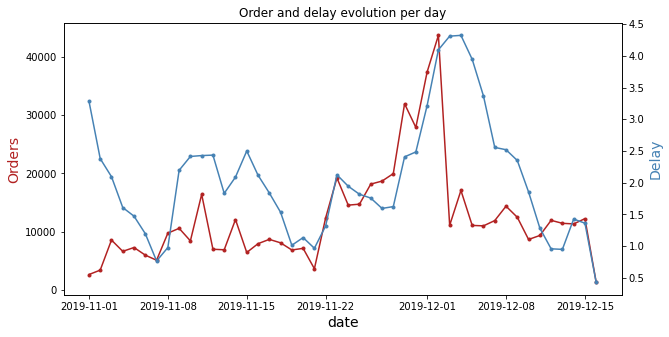

In [11]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(order_per_day.index, order_per_day, color="firebrick", marker=".")
ax.set_xlabel("date",fontsize=14)
ax.set_ylabel("Orders",color="firebrick",fontsize=14)

ax2=ax.twinx()
ax2.plot(delay_per_day.index, delay_per_day,color="steelblue",marker=".")
ax2.set_ylabel("Delay",color="steelblue",fontsize=14)

plt.title('Order and delay evolution per day')
plt.show()

As we see in this graph, we cannot say that number of order and delays are correlated to each other.

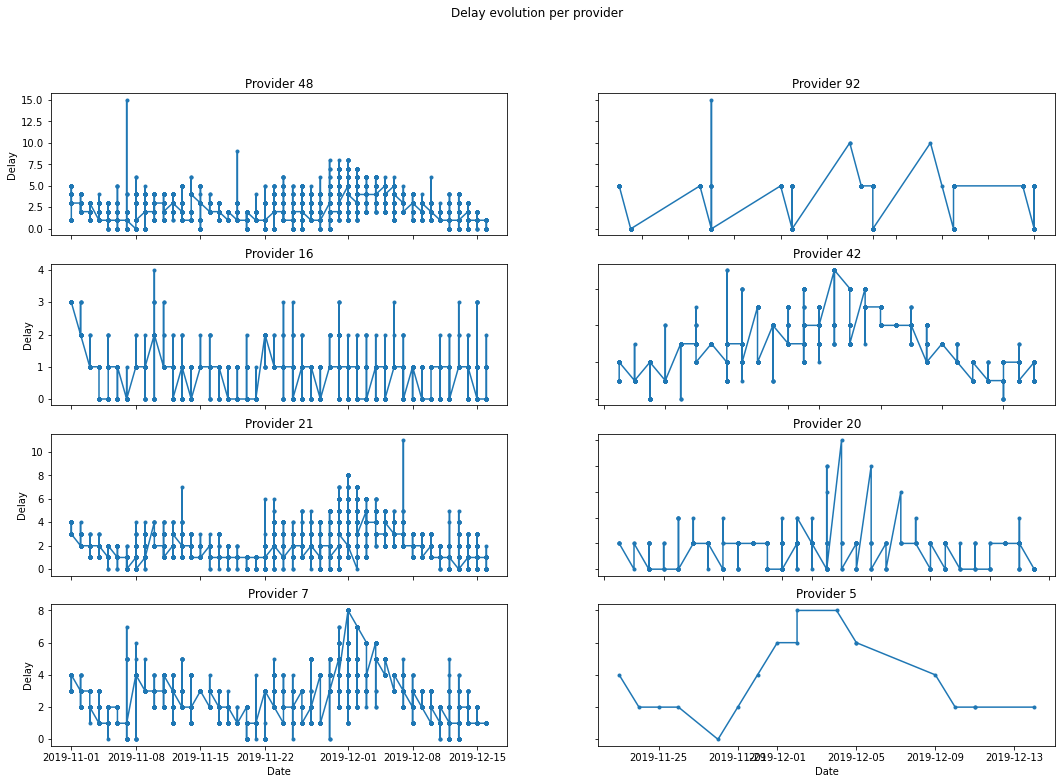

In [12]:
fig, axs = plt.subplots(4, 2)
fig.set_size_inches(18, 12)
fig.suptitle('Delay evolution per provider')

iterator = 0
for provider in df['provider_id'].unique():
    ax_x_index = iterator % 4
    ax_y_index = iterator // 4

    iterator += 1

    provider_data = df[df['provider_id'] == provider].sort_values('order_date')

    axs[ax_x_index, ax_y_index].plot('order_date', 'delay', data=provider_data, marker='.')
    axs[ax_x_index, ax_y_index].set_title(f'Provider {provider}')

for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='Delay')

for ax in axs.flat:
    ax.label_outer()

In [13]:
# Order per day and per provider
order_per_day_and_provider = df.groupby(['order_date', 'provider_id'])['order_date'].count()
order_per_day_and_provider.to_frame(name='number of orders').reset_index()

,order_date,provider_id,number of orders
0,2019-11-01,5,0
1,2019-11-01,7,169
2,2019-11-01,16,62
3,2019-11-01,20,0
4,2019-11-01,21,265
...,...,...,...
363,2019-12-16,20,15
364,2019-12-16,21,352
365,2019-12-16,42,0
366,2019-12-16,48,536


In [14]:
# Average delay per day and per provider
delay_per_day_and_provider = df.groupby(['order_date', 'provider_id']).mean("delay")['delay']
delay_per_day_and_provider.to_frame(name='delay').reset_index()

,order_date,provider_id,delay
0,2019-11-01,5,NaN
1,2019-11-01,7,3.828402
2,2019-11-01,16,3.000000
3,2019-11-01,20,NaN
4,2019-11-01,21,3.452830
...,...,...,...
363,2019-12-16,20,0.000000
364,2019-12-16,21,0.500000
365,2019-12-16,42,NaN
366,2019-12-16,48,0.602612


In [15]:
# Performance by provider
df.groupby('provider_id')['delay'].describe()[['count', 'mean', 'min', 'max']].rename(columns={
    'count': 'nb_deliveries', 
    'mean': 'mean_delay', 
    'min': 'min_delay', 
    'max': 'max_delay'
}).sort_values(by='mean_delay')

,nb_deliveries,mean_delay,min_delay,max_delay
provider_id,,,,
92,1640.0,0.377439,0.0,3.0
16,10019.0,0.680208,0.0,4.0
20,400.0,0.730000,0.0,5.0
21,75872.0,1.893373,0.0,11.0
48,442881.0,2.366358,0.0,15.0
5,18.0,2.888889,1.0,5.0
7,36361.0,2.998735,0.0,8.0
42,5647.0,3.390827,0.0,7.0


In [16]:
# Order hours in the day

time_12 = datetime.datetime.strptime('12:00', '%H:%M').time()
time_18 = datetime.datetime.strptime('18:00', '%H:%M').time()

# Order taken before 12pm
order_before_12 = df[df['order_time'] < time_12]

# Order taken between 12pm & 6pm
order_between_12_18 = df[(df['order_time'] >= time_12) & (df['order_time'] < time_18)]

# Order taken after 6pm
order_after_18 = df[df['order_time'] >= time_18]

In [17]:
print('Order done before 12')
print('-'*2)
print('Mean delay:', order_before_12['delay'].mean())
print('Minimum delay:', order_before_12['delay'].min())
print('Maximum delay:', order_before_12['delay'].max())
print('*'*10)
print('Order done between 12 and 18')
print('-'*2)
print('Mean delay:', order_between_12_18['delay'].mean())
print('Minimum delay:', order_between_12_18['delay'].min())
print('Maximum delay:', order_between_12_18['delay'].max())
print('*'*10)
print('Order done after 18')
print('-'*2)
print('Mean delay:', order_after_18['delay'].mean())
print('Minimum delay:', order_after_18['delay'].min())
print('Maximum delay:', order_after_18['delay'].max())

Order done before 12
--
Mean delay: 2.0572830323939244
Minimum delay: 0
Maximum delay: 15
**********
Order done between 12 and 18
--
Mean delay: 2.2452033388291714
Minimum delay: 0
Maximum delay: 8
**********
Order done after 18
--
Mean delay: 2.5678105959046977
Minimum delay: 0
Maximum delay: 11


In [18]:
order_period_conditions = [
    (df['order_time'] < time_12),
    (df['order_time'] >= time_12) & (df['order_time'] < time_18),
    (df['order_time'] >= time_18)
]

order_period_values = [
    'before_12',
    'between_12_18',
    'after_18'
]

df.loc[:, 'order_period'] = np.select(order_period_conditions, order_period_values)
df.loc[:, 'order_period'] = df.loc[:, 'order_period'].astype('category')

In [19]:
# If the order was taken on weekdays or weekends
df['is_week_day'] = np.where(df['order_date'].dt.dayofweek > 4, 0, 1)

In [20]:
df.sample(15)

,provider_id,order_date,order_time,order_stock,expedition_date,delay,order_period,is_week_day
251233,48,2019-12-02,13:00:00,43653,2019-12-05,3,between_12_18,1
122987,48,2019-11-17,09:00:00,8672,2019-11-19,2,before_12,0
553878,48,2019-12-08,14:00:00,14360,2019-12-11,3,between_12_18,0
219975,48,2019-11-26,16:00:00,18148,2019-11-28,2,between_12_18,1
518327,48,2019-12-12,13:00:00,11934,2019-12-13,1,between_12_18,1
230524,48,2019-11-27,15:00:00,18666,2019-11-28,1,between_12_18,1
207034,7,2019-11-23,22:00:00,19213,2019-11-25,2,after_18,0
352098,48,2019-12-03,18:00:00,11086,2019-12-08,5,after_18,1
541084,48,2019-12-15,17:00:00,12223,2019-12-16,1,between_12_18,0
486473,48,2019-12-03,05:00:00,11086,2019-12-08,5,before_12,1


## Model selection

Algorithm that are suitable for this kind of problem are : 
- Linear regression
- Polynomial regression
- Random Forest Regressor
- Ridge
- XGBoost
- Neural Network

In [21]:
#pip install --user xgboost

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor

print(tf.__version__)

2.3.1


In [23]:
tmp_df = df[['order_date', 'provider_id','delay', 'order_stock', 'is_week_day', 'order_period']]

In [24]:
tmp_df = pd.get_dummies(tmp_df, columns=['order_period'])

tmp_df

,order_date,provider_id,delay,order_stock,is_week_day,order_period_after_18,order_period_before_12,order_period_between_12_18
0,2019-11-01,48,1,2641,1,0,1,0
1,2019-11-01,48,1,2641,1,0,1,0
2,2019-11-01,48,1,2641,1,0,1,0
3,2019-11-01,48,1,2641,1,0,0,1
4,2019-11-01,48,1,2641,1,0,0,1
...,...,...,...,...,...,...,...,...
572836,2019-12-16,48,1,1286,1,0,1,0
572837,2019-12-16,48,1,1286,1,0,1,0
572838,2019-12-15,48,2,12223,0,1,0,0
572839,2019-12-15,48,2,12223,0,1,0,0


In [25]:
tmp_df['order_date'] = pd.to_numeric(pd.to_datetime(tmp_df['order_date']))

In [26]:
train_data, test_data = train_test_split(tmp_df, test_size=0.2, random_state = 100)
X_train = train_data.iloc[:, 1:]
y_train = train_data.loc[:, 'delay']

X_test = test_data.iloc[:, 1:]
y_test = test_data.loc[:, 'delay']

In [27]:
def accuracy(actual, predictions): 
    count = 0 
    for _ in range(len(actual)): 
        if actual[_] == int(round(predictions[_])):
            count += 1
    return (count/len(actual))*100

#### Linear regression

In [28]:
model = LinearRegression() 
model.fit(X_train, y_train)
model.score(X_train, y_train)

1.0

In [29]:
predictions = model.predict(X_test)

In [30]:
accuracy(y_test.tolist(), predictions.tolist())

100.0

Hum, an accuracy of 100% and R² score at 1.0 seems too perfect to be true, there must be overfitting... 

In [31]:
# With cross validation using k-folds
lm = LinearRegression() 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=folds)
scores 

array([1., 1., 1., 1., 1.])

In [32]:
# create a cross-validation scheme
folds = KFold(n_splits = 25, shuffle = True, random_state = 100)

# specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1,6))}]


# perform grid search
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)  

Fitting 25 folds for each of 5 candidates, totalling 125 fits


GridSearchCV(cv=KFold(n_splits=25, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5]}],
             return_train_score=True, scoring='r2', verbose=1)

In [33]:
predict = model_cv.predict(X_test)
accuracy(y_test.tolist(), predict.tolist())

100.0

#### Polynomial Regression

In [34]:
pr = Pipeline([('poly', PolynomialFeatures(degree=3)), ('linear', LinearRegression(fit_intercept=False))])

# fit to an order-3 polynomial data
pr = pr.fit(X_train, y_train)
pr.named_steps['linear'].coef_

array([ 8.40690951e-01, -1.90167534e-02,  5.00323050e-01, -8.06159173e-06,
       -2.73183864e-01,  3.97500057e-02, -9.42420398e-02, -4.82262119e-02,
        2.78092819e-04,  2.03466697e-03, -2.25704869e-07,  2.17453445e-02,
       -7.85506865e-03, -5.14378785e-03, -5.63959523e-03,  3.83283166e-04,
        1.07776113e-06,  7.93272519e-02,  1.45855021e-01,  1.81214884e-01,
        1.73250107e-01,  1.37946623e-09,  1.08950201e-05, -2.36911653e-06,
       -2.36566564e-06, -3.31054008e-06, -2.73183880e-01, -1.65112327e-01,
       -2.07209729e-02, -8.73505803e-02,  3.97500121e-02, -2.13232210e-14,
       -2.23779328e-15, -9.42420556e-02,  5.34988720e-15, -4.82262129e-02,
        1.79220174e-06,  7.64885117e-06,  3.92104432e-10, -7.13381101e-04,
        7.10990510e-05,  1.04956852e-04,  1.02058349e-04, -8.79026554e-05,
        2.40740569e-08, -4.16352237e-03,  6.68043509e-04,  8.01360855e-04,
        5.65262427e-04,  1.85906845e-12,  1.28267572e-07,  3.70685893e-08,
       -1.23862219e-07, -

In [35]:
pr_predictions = pr.predict(X_test)

In [36]:
accuracy(y_test.tolist(), pr_predictions.tolist())

99.97294183367083

#### Random Forest

In [37]:
model = RandomForestRegressor() 
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.999994533430155

In [38]:
predictions = model.predict(X_test)

In [39]:
accuracy(y_test.tolist(), predictions.tolist())

100.0

#### Ridge

In [40]:
model = Ridge() 
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.9999999999973451

In [41]:
predictions = model.predict(X_test)

In [42]:
accuracy(y_test.tolist(), predictions.tolist())

100.0

#### XGBoost

In [43]:
#xgb = XGBoostRegressor()
#xgb.fit(X_train, y_train)
#xgb_pred = xgb.predict(X_test)
#accuracy(y_test.tolist(), xgb_pred)

#### Neural Network

In [44]:
nn = keras.Sequential([
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

nn.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
nn.fit(X_train, y_train, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
11457/11457 [==============================] - 12s 1ms/step - loss: 91653.7734 - accuracy: 0.1826 - val_loss: 1.4426 - val_accuracy: 0.2447
Epoch 2/5
11457/11457 [==============================] - 12s 1ms/step - loss: 3.9662 - accuracy: 0.2454 - val_loss: 1.5186 - val_accuracy: 0.2447
Epoch 3/5
11457/11457 [==============================] - 11s 1ms/step - loss: 1.6178 - accuracy: 0.2462 - val_loss: 1.5187 - val_accuracy: 0.2447
Epoch 4/5
11457/11457 [==============================] - 12s 1ms/step - loss: 1.5404 - accuracy: 0.2462 - val_loss: 1.5187 - val_accuracy: 0.2447
Epoch 5/5
11457/11457 [==============================] - 13s 1ms/step - loss: 1.5454 - accuracy: 0.2462 - val_loss: 1.5188 - val_accuracy: 0.2447


There is not enough data to perform a goot neural network, the best accuracy I could get was around 25%

## Production

An ML model can provide predictions in two ways:
- **Offline prediction** 
This is when your ML model is used in a batch scoring job for a large number of data points, where predictions are not required in real-time serving. In offline recommendations, for example, you only use historical information about customer-item interactions to make the prediction, without any need for online information. Offline recommendations are usually performed in retention campaigns for (inactive) customers with high propensity to churn, in promotion campaigns, and so on.
- **Online prediction**
This is when your ML system is used to serve real-time predictions, based on online requests from the operational systems and apps. In contrast to offline prediction, in online recommendations you need the current context of the customer who's using your application, along with historical information, to make the prediction. This context includes information such as datetime, page views, funnels,items viewed, items in the basket, items removed from the basket, customer device, and device location.

To optimize the ML model for low read-latency prediction, you can try the following:
- Using smaller model sizes by reducing the number of input features and/or reducing the model complexity. Examples include reducing hidden units in neural networks, levels in decision trees, and the number of trees in boosted trees.
- Removing unused, redundant, or irrelevant parts of the model for serving. This step is usually needed as you promote your model from training mode to prediction mode.